In [2]:
import import_ipynb
import sys,os
sys.path.append(os.getcwd())

import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
%matplotlib inline

In [3]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [4]:
#set the root to the Shanghai dataset you download
root = 'D:/Sahal/Project/ShanghaiTech/'

In [5]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_B_train = os.path.join(root,'part_B/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')
path_sets = [part_A_train,part_A_test]


In [6]:
img_paths = []

for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
            img_paths.append(img_path)
    print(img_paths)

['D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_1.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_10.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_100.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_101.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_102.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_103.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_104.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_105.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_106.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_107.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_108.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_109.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_11.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_110.j

['D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_1.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_10.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_100.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_101.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_102.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_103.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_104.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_105.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_106.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_107.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_108.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_109.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_11.jpg', 'D:/Sahal/Project/ShanghaiTech/part_A/train_data\\images\\IMG_110.j

In [8]:

for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

D:/Sahal/Project/ShanghaiTech/part_A/train_data\images\IMG_1.jpg
(768, 1024)
generate density...


KeyboardInterrupt: 

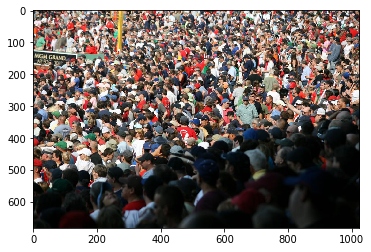

In [9]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[1]))

In [13]:
np.sum(groundtruth)# don't mind this slight variation

904.1688

In [15]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [16]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [18]:
path_sets = [part_B_train,part_B_test]
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
        
# creating density map for part_b images

for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
            hf['density'] = k

D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_1.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_10.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_100.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_101.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_102.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_103.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_104.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_105.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_106.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG

D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_17.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_170.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_171.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_172.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_173.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_174.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_175.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_176.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_177.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\I

D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_24.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_240.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_241.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_242.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_243.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_244.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_245.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_246.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_247.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\I

D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_31.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_310.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_311.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_312.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_313.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_314.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_315.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_316.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_317.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\I

D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_380.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_381.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_382.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_383.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_384.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_385.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_386.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_387.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_388.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\

(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_91.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_92.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_93.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_94.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_95.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_96.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_97.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_98.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiTech/part_B/train_data\images\IMG_99.jpg
(768, 1024)
generate density...
done.
D:/Sahal/Project/ShanghaiT

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Sahal/Project/ShanghaiTech/part_B/test_data\\ground-truth\\GT_IMG_1.mat'

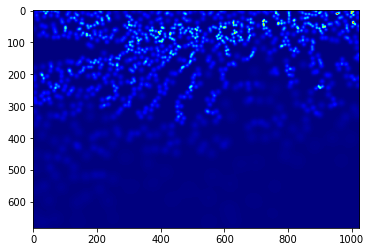

In [12]:
gt_file = h5py.File(img_paths[1].replace('.jpg','.h5').replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [10]:
img_path = 'D:/Sahal/Project/ShanghaiTech/part_A/train_data/images/IMG_1.jpg'
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
img= plt.imread(img_path)
k = np.zeros((img.shape[0],img.shape[1]))
gt = mat["image_info"][0,0][0,0][0]

for i in range(0,len(gt)):
    if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
        k[int(gt[i][1]),int(gt[i][0])]=1
k = gaussian_filter_density(k)
print (np.sum(k))
assert(np.sum(k) == len(gt))

(768, 1024)
generate density...
done.
1543.841


AssertionError: 